In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_og = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train, val = torch.utils.data.random_split(train_og, [len(train_og) - int(0.1 * len(train_og)), int(0.1 * len(train_og))])


trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Self-Attention Layer

In [4]:
X_rand = torch.rand((16, 32, 32, 64))
# WQ_rand = torch.rand((3, 32, 32))

# Q = X_rand @ WQ_rand

In [5]:
X_rand.shape

torch.Size([16, 32, 32, 64])

In [6]:
class SelfAttention2(nn.Module):
    def __init__(self):
        super().__init__()

        
    def forward(self,X):

        N,c,w,h = X.shape
        X.to(device)

        
        cK = nn.Conv2d(c, c//8, 1).to(device=device)
        cQ = nn.Conv2d(c, c//8, 1).to(device=device)
        cV = nn.Conv2d(c, c, 1).to(device=device)

        self.Q =  cK(X).view(N, -1, w * h).permute(0, 2, 1)
        self.Kt = cQ(X).view(N, -1, w * h).to(device=device)
        self.V = cV(X).view(N, -1, w * h).permute(0, 2, 1)



        outLogits = self.Q @ self.Kt
        # outLogits.to(device=device)
        # print(outLogits.shape)
        # print(self.V.shape)

        Y = F.softmax(outLogits/  torch.sqrt(torch.tensor([w*h])).to(device=device)  ).to(device=device) @ self.V.to(device=device)
        
        Y = Y.view(N, w, h, c).permute(0, 3,1, 2)

        layer_norm = nn.LayerNorm(X.size()[1:]).to(device)

        # print(X.shape,Y.shape)
        return layer_norm(Y+X)

In [7]:
X_rand.shape

torch.Size([16, 32, 32, 64])

In [8]:
SA2= SelfAttention2()

# Y.shape

In [9]:
Y  = SA2.forward(X_rand.to(device=device))

/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
Y.shape

torch.Size([16, 32, 32, 64])

### Final NN

In [11]:
def GAP(X):

    b,c,w,h = X.shape

    retTensor = torch.zeros((b,c)).to(device=device)

    gap = nn.AdaptiveAvgPool2d(1)
    for i in range(b):

        # print(gap(X[i]).squeeze().shape)
        retTensor[i] = gap(X[i]).squeeze()

    return retTensor

In [12]:


class NN_SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 11).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        
        self.conv2 = nn.Conv2d(32, 64, 1).to(device)
        self.SA1 = SelfAttention2()
        
        self.conv3 = nn.Conv2d(64, 128, 1).to(device)
        self.SA2 = SelfAttention2()
        
        self.conv4 = nn.Conv2d(128, 512, 1).to(device)
        self.SA3 = SelfAttention2()
        
        self.conv5 = nn.Conv2d(512, 1024, 1).to(device)
        self.SA4 = SelfAttention2()

        self.conv6 = nn.Conv2d(1024, 1024, 1).to(device)
        
        # self.GAP = nn.AdaptiveAvgPool2d(1)
        self.GAP = GAP

        self.fc1 = nn.Linear(1024, 2048).to(device)
        self.fc2 = nn.Linear(2048, 1024).to(device)
        self.fc3 = nn.Linear(1024, 512).to(device)
        self.fc4 = nn.Linear(512, 128).to(device)
        self.fc5 = nn.Linear(128, 10).to(device)
        

    def forward(self, x):
        
        # Conv + Self Attention
        x = F.relu(self.conv1(x))
    
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.SA1.forward(x)
    

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.SA2.forward(x)

        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.SA3.forward(x)


        x = F.relu(self.conv5(x))

        x = self.SA4.forward(x)

        x = F.relu(self.conv6(x))


        
        # GAP
        x = self.GAP(x)

        # MLP
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        return x


net = NN_SelfAttention()

In [13]:
net.to(device)

NN_SelfAttention(
  (conv1): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (SA1): SelfAttention2()
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (SA2): SelfAttention2()
  (conv4): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
  (SA3): SelfAttention2()
  (conv5): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
  (SA4): SelfAttention2()
  (conv6): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
dataiter = iter(trainloader)


In [15]:
images,labels = next(dataiter)

In [16]:
images.shape

torch.Size([128, 3, 32, 32])

In [17]:
outputs = net(images.to(device))

/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [18]:
outputs.shape

torch.Size([128, 10])

In [19]:
outputs

tensor([[0.0547, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0547, 0.0000, 0.0102,  ..., 0.0000, 0.0000, 0.0000],
        [0.0534, 0.0000, 0.0084,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0560, 0.0000, 0.0094,  ..., 0.0000, 0.0000, 0.0000],
        [0.0526, 0.0000, 0.0109,  ..., 0.0000, 0.0000, 0.0000],
        [0.0537, 0.0000, 0.0099,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)

### Training Loop

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [21]:

total_trainingloss = []
total_valloss = []

total_training_acc = []
total_val_acc = []

for epoch in range(40):
    correct_train = 0
    total_train = 0

    train_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        try:
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()


            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted.to(device) == labels.to(device)).sum().item()
        except Exception as e:
            print("I got an error")
            print(f'Error is {e}')
            pass


    # print(f'Training Loss is" {running_loss}')
    # print(f'Train accuracy after epoch {i}: {(epoch + 1, 100 * correct_val / total_val)}')
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss is: {train_loss:.2f}')
    total_trainingloss.append(train_loss)
    print(f'Train Accuracy is: {(100*correct_train/total_train):.2f} %')

    total_training_acc.append(correct_train/total_train)

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            try:
                inputs, labels = data
                outputs = net(inputs.to(device))
                Valloss = criterion(outputs, labels.to(device))
                
                val_loss += Valloss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted.to(device) == labels.to(device)).sum().item()
            except:
                print("I got an error")
                pass
    
    print(f'Val Loss is: {val_loss:.2f}')
    total_valloss.append(val_loss)
    print(f'Val Accuracy is: {(100*correct_val/total_val):.2f} %')
    total_val_acc.append(correct_val/total_val)
    print('----------------------------------------------------')
 
 


0it [00:00, ?it/s]/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
352it [00:09, 37.98it/s]

Epoch: 1
Train Loss is: 750.82
Train Accuracy is: 20.45 %


Val Loss is: 83.91
Val Accuracy is: 24.12 %
----------------------------------------------------


352it [00:09, 37.44it/s]

Epoch: 2
Train Loss is: 701.17
Train Accuracy is: 27.80 %


Val Loss is: 78.40
Val Accuracy is: 30.78 %
----------------------------------------------------


352it [00:09, 38.34it/s]

Epoch: 3
Train Loss is: 663.74
Train Accuracy is: 32.85 %


Val Loss is: 73.88
Val Accuracy is: 34.68 %
----------------------------------------------------


352it [00:08, 39.99it/s]

Epoch: 4
Train Loss is: 637.11
Train Accuracy is: 36.45 %


Val Loss is: 72.34
Val Accuracy is: 37.36 %
----------------------------------------------------


352it [00:09, 37.46it/s]

Epoch: 5
Train Loss is: 615.92
Train Accuracy is: 39.60 %


Val Loss is: 70.22
Val Accuracy is: 41.56 %
----------------------------------------------------


352it [00:09, 37.73it/s]

Epoch: 6
Train Loss is: 597.68
Train Accuracy is: 42.19 %


Val Loss is: 74.42
Val Accuracy is: 42.60 %
----------------------------------------------------


352it [00:09, 36.60it/s]

Epoch: 7
Train Loss is: 571.69
Train Accuracy is: 44.22 %


Val Loss is: 64.71
Val Accuracy is: 45.00 %
----------------------------------------------------


352it [00:09, 37.77it/s]

Epoch: 8
Train Loss is: 541.88
Train Accuracy is: 47.30 %


Val Loss is: 65.56
Val Accuracy is: 45.78 %
----------------------------------------------------


352it [00:08, 39.21it/s]

Epoch: 9
Train Loss is: 526.48
Train Accuracy is: 49.10 %


Val Loss is: 61.67
Val Accuracy is: 48.84 %
----------------------------------------------------


352it [00:09, 38.65it/s]

Epoch: 10
Train Loss is: 505.57
Train Accuracy is: 50.63 %


Val Loss is: 59.94
Val Accuracy is: 49.26 %
----------------------------------------------------


352it [00:09, 38.08it/s]

Epoch: 11
Train Loss is: 466.47
Train Accuracy is: 52.52 %


Val Loss is: 56.21
Val Accuracy is: 51.66 %
----------------------------------------------------


352it [00:09, 37.06it/s]

Epoch: 12
Train Loss is: 452.04
Train Accuracy is: 54.05 %


Val Loss is: 53.82
Val Accuracy is: 52.94 %
----------------------------------------------------


352it [00:09, 37.47it/s]

Epoch: 13
Train Loss is: 437.50
Train Accuracy is: 55.69 %


Val Loss is: 54.43
Val Accuracy is: 54.50 %
----------------------------------------------------


352it [00:08, 39.68it/s]

Epoch: 14
Train Loss is: 428.84
Train Accuracy is: 56.35 %


Val Loss is: 53.75
Val Accuracy is: 53.98 %
----------------------------------------------------


352it [00:09, 36.89it/s]

Epoch: 15
Train Loss is: 414.99
Train Accuracy is: 57.66 %


Val Loss is: 55.27
Val Accuracy is: 56.14 %
----------------------------------------------------


352it [00:08, 39.43it/s]

Epoch: 16
Train Loss is: 404.06
Train Accuracy is: 58.93 %


Val Loss is: 53.05
Val Accuracy is: 55.98 %
----------------------------------------------------


352it [00:09, 38.16it/s]

Epoch: 17
Train Loss is: 398.74
Train Accuracy is: 59.64 %


Val Loss is: 53.40
Val Accuracy is: 56.10 %
----------------------------------------------------


352it [00:09, 36.71it/s]

Epoch: 18
Train Loss is: 388.86
Train Accuracy is: 60.54 %


Val Loss is: 54.20
Val Accuracy is: 56.34 %
----------------------------------------------------


352it [00:09, 38.02it/s]

Epoch: 19
Train Loss is: 373.40
Train Accuracy is: 62.00 %


Val Loss is: 51.27
Val Accuracy is: 56.90 %
----------------------------------------------------


352it [00:09, 37.50it/s]

Epoch: 20
Train Loss is: 365.50
Train Accuracy is: 62.83 %


Val Loss is: 51.41
Val Accuracy is: 56.42 %
----------------------------------------------------


352it [00:09, 37.70it/s]

Epoch: 21
Train Loss is: 358.13
Train Accuracy is: 63.76 %


Val Loss is: 50.81
Val Accuracy is: 57.82 %
----------------------------------------------------


352it [00:09, 38.31it/s]

Epoch: 22
Train Loss is: 347.20
Train Accuracy is: 64.66 %


Val Loss is: 53.24
Val Accuracy is: 57.38 %
----------------------------------------------------


352it [00:09, 38.13it/s]

Epoch: 23
Train Loss is: 337.02
Train Accuracy is: 65.84 %


Val Loss is: 54.66
Val Accuracy is: 57.44 %
----------------------------------------------------


352it [00:09, 37.66it/s]

Epoch: 24
Train Loss is: 328.71
Train Accuracy is: 66.40 %


Val Loss is: 56.75
Val Accuracy is: 58.02 %
----------------------------------------------------


352it [00:09, 38.61it/s]

Epoch: 25
Train Loss is: 318.48
Train Accuracy is: 67.57 %


Val Loss is: 52.57
Val Accuracy is: 59.14 %
----------------------------------------------------


352it [00:08, 39.33it/s]

Epoch: 26
Train Loss is: 305.53
Train Accuracy is: 68.74 %


Val Loss is: 52.78
Val Accuracy is: 58.90 %
----------------------------------------------------


352it [00:09, 38.98it/s]

Epoch: 27
Train Loss is: 296.05
Train Accuracy is: 70.11 %


Val Loss is: 52.70
Val Accuracy is: 57.70 %
----------------------------------------------------


352it [00:09, 37.97it/s]

Epoch: 28
Train Loss is: 287.17
Train Accuracy is: 70.65 %


Val Loss is: 53.49
Val Accuracy is: 57.98 %
----------------------------------------------------


352it [00:09, 37.81it/s]

Epoch: 29
Train Loss is: 276.90
Train Accuracy is: 71.84 %


Val Loss is: 56.59
Val Accuracy is: 58.62 %
----------------------------------------------------


352it [00:08, 39.32it/s]

Epoch: 30
Train Loss is: 264.94
Train Accuracy is: 73.10 %


Val Loss is: 54.89
Val Accuracy is: 57.50 %
----------------------------------------------------


352it [00:09, 37.48it/s]

Epoch: 31
Train Loss is: 253.01
Train Accuracy is: 74.34 %


Val Loss is: 59.00
Val Accuracy is: 57.12 %
----------------------------------------------------


352it [00:09, 37.60it/s]

Epoch: 32
Train Loss is: 243.84
Train Accuracy is: 75.11 %


Val Loss is: 61.43
Val Accuracy is: 57.88 %
----------------------------------------------------


352it [00:09, 37.62it/s]

Epoch: 33
Train Loss is: 230.87
Train Accuracy is: 76.47 %


Val Loss is: 62.72
Val Accuracy is: 57.46 %
----------------------------------------------------


352it [00:09, 37.70it/s]

Epoch: 34
Train Loss is: 219.61
Train Accuracy is: 77.70 %


Val Loss is: 60.91
Val Accuracy is: 58.26 %
----------------------------------------------------


352it [00:09, 38.22it/s]

Epoch: 35
Train Loss is: 211.26
Train Accuracy is: 78.59 %


Val Loss is: 61.78
Val Accuracy is: 57.44 %
----------------------------------------------------


352it [00:09, 38.32it/s]

Epoch: 36
Train Loss is: 196.93
Train Accuracy is: 80.23 %


Val Loss is: 63.75
Val Accuracy is: 57.80 %
----------------------------------------------------


352it [00:09, 37.67it/s]

Epoch: 37
Train Loss is: 191.46
Train Accuracy is: 80.66 %


Val Loss is: 64.37
Val Accuracy is: 58.00 %
----------------------------------------------------


352it [00:09, 38.25it/s]

Epoch: 38
Train Loss is: 178.74
Train Accuracy is: 81.90 %


Val Loss is: 66.55
Val Accuracy is: 57.30 %
----------------------------------------------------


352it [00:09, 36.98it/s]

Epoch: 39
Train Loss is: 171.30
Train Accuracy is: 82.76 %


Val Loss is: 67.21
Val Accuracy is: 58.14 %
----------------------------------------------------


352it [00:09, 38.39it/s]

Epoch: 40
Train Loss is: 158.57
Train Accuracy is: 83.86 %


Val Loss is: 75.73
Val Accuracy is: 57.88 %
----------------------------------------------------


In [22]:
def lossPlotter(training_loss,val_loss,type="Loss"):
    x = range(len(training_loss))

    y1 = training_loss
    y2 = val_loss

    

    fig, ax1 = plt.subplots()


    
    plt.plot(x,y1, label=f'Training {type}')
    plt.plot(x,y2, label=f'Validation {type}')
    
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    
    plt.title(f'{type} Plot')
    plt.legend()
    plt.show()


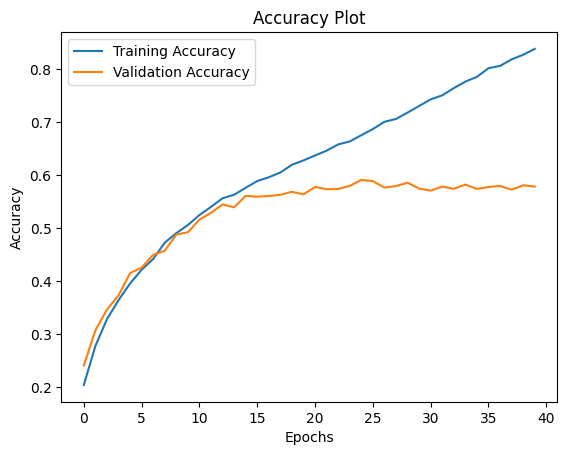

In [23]:
lossPlotter(training_loss=total_training_acc,val_loss=total_val_acc,type="Accuracy")

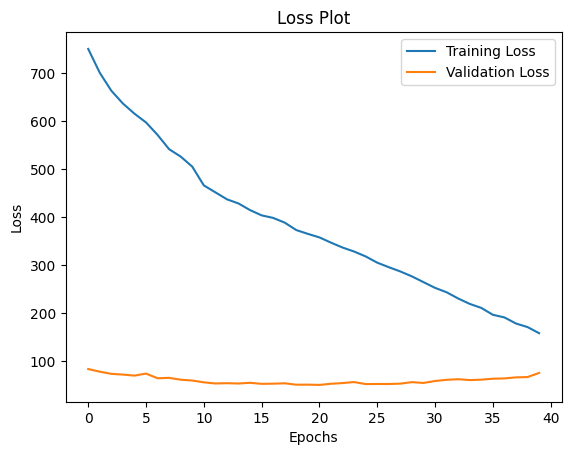

In [24]:
lossPlotter(training_loss=total_trainingloss,val_loss=total_valloss,type="Loss")

In [25]:
from  datetime import datetime

In [26]:
current_datetime = datetime.now()
current_datetime.strftime("%Y-%m-%d %H:%M:%S")

PATH = f'./cifar_SA-CNN_{total_training_acc[-1]:.2f}__{current_datetime}.pth'
torch.save(net.state_dict(), PATH)

In [21]:
PATH = 'cifar_SA-CNN_0.84__2024-03-29 18:55:08.107941.pth'

In [22]:
CNN_SelfAtt = NN_SelfAttention()
CNN_SelfAtt.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:

test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = CNN_SelfAtt(inputs.to(device))
        testloss = criterion(outputs, labels.to(device))
        
        test_loss += testloss.item()

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted.to(device) == labels.to(device)).sum().item()

    print(f'Test Loss is: {testloss:.2f}')
    print(f'Test Accuracy is: {(100*correct_test/total_test):.2f} %')
    print('----------------------------------------------------')

/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss is: 3.21
Test Accuracy is: 55.76 %
----------------------------------------------------


Metrics of Conv+SA and ViT:

- Conv+SA:
    - Train:83.86 %

    - Test: 55.76 %

    - Val: 57.88 %

- ViT:
    - Train: 61.85 %

    - Test: 30.74 %

    - Val: 45.66 %


Upon comparison of the two models, CNN+ Self Attention Model is performing better